In [2]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [3]:
from kid_readout.interactive import *

INFO: 2016-06-23 13:59:47,298 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [4]:
logger.setLevel(logging.DEBUG)

In [5]:
from kid_readout.analysis import detect_peaks

In [22]:
def find_resonators(frequency, s21, s21_error, frequency_span=1e6, detect_peaks_threshold=3, detect_peaks_kwargs=dict(),
                    make_plot=False,annotate=False):
    unique_mask = np.flatnonzero(np.diff(frequency)!=0)
    frequency = frequency[unique_mask]
    s21 = s21[unique_mask]
    s21_error = s21_error[unique_mask]
    mag_s21 = np.abs(s21)
    peak_indexes = detect_peaks.detect_peaks(-mag_s21,threshold=detect_peaks_threshold,**detect_peaks_kwargs)
    peak_indexes2 = detect_peaks.detect_peaks(-mag_s21[::2],threshold=detect_peaks_threshold,**detect_peaks_kwargs)
    peak_indexes = np.sort(np.array(list(set(peak_indexes) | set(peak_indexes2*2))))
    logger.debug("Found %d peaks",peak_indexes.shape[0])
    resonators = []
    for peak_index in peak_indexes:
        peak_f = frequency[peak_index]
        sub_mask = np.abs(peak_f-frequency) < frequency_span
        res = lmfit_resonator.LinearResonatorWithCable(frequency[sub_mask], s21[sub_mask],s21_error[sub_mask])
        if res.current_result.redchi > 1000:
            res2 = lmfit_resonator.CollidingLinearResonatorsWithCable(frequency[sub_mask], s21[sub_mask],s21_error[sub_mask])
            if res2.current_result.redchi < 1000:
                logger.info("Found possible resonator colision at %.1f  %.1f" % (res2.bg_f_0,res2.fg_f_0))
#            
#        else:
        resonators.append(res)
    if make_plot:
        plot_results(frequency,s21,resonators,peak_indexes,frequency_span,annotate=annotate)
    return resonators

def plot_results(frequency, s21, resonators, peak_indexes=[], frequency_span=250e3,annotate=True):
    plt.plot(frequency/1e6,20*np.log10(np.abs(s21)))
    for peak_index in peak_indexes:
        peak_f = frequency[peak_index]
        plt.plot(peak_f/1e6,20*np.log10(np.abs(s21[peak_index])),'r+',mew=2,markersize=10)
        
    for res in resonators:
        if res.Q_i < 2000:
            color='gray'
        elif res.Q_i < 10e3:
            color='k'
        elif res.Q_i < 100e3:
            color='m'
        else:
            color='r'
        dB_s21_at_f_0 = 20*np.log10(np.abs(res.model.eval(params=res.current_params,f=res.f_0)))
        sub_mask = np.abs(res.f_0-frequency) < frequency_span
        plt.plot(frequency[sub_mask]/1e6,20*np.log10(np.abs(res.model.eval(params=res.current_params,f=frequency[sub_mask]))))
        plt.plot(res.f_0/1e6,dB_s21_at_f_0,'o')
        if annotate:
            plt.annotate(xy=(res.f_0/1e6, dB_s21_at_f_0), s=('Q: %.1f\nQc: %.1f\nQi: %.1f\nchi2: %.1f' % (res.Q,1/np.real(1/res.Q_e),res.Q_i,res.current_result.redchi)),
            size=8,textcoords='offset points',xytext=(10,-10),color=color)


In [7]:
def remove_duplicates(resonators,tolerance=50e3):
    clean = []
    f0s = []
    for p in resonators:
        f0 = p.f_0
#        f0 = p['f_0'].value
        if len(clean) == 0:
            clean.append(p)
            f0s.append(f0)
            continue
        distance = np.abs(f0-np.array(f0s))
        if not np.any(distance < tolerance):
            clean.append(p)
            f0s.append(f0)
        else:
            print "found duplicate of ", f0, "distance", distance.min()

    return clean

In [8]:
def validate_resonator(res):
    print res.f_0,
    Qe = 1/np.real(1/res.Q_e)
    if res.Q / np.abs(Qe) < 0.01:
        print "failed shallow"
        return False
    if Qe < 1000:
        print "failed low Qe"
        return False
    if res.Q_e_real > 1e6:
        print "failed high Qer"
        return False
    if np.abs(res.Q_e_imag) > 1e6:
        print "failed high Qei"
        return False
    if Qe > 1e6:
        print "failed high Qe"
    if res.Q < 1000:
        print "failed low Q"
        return False
#    if res.current_result.redchi > 1000:
#        print "failed redchi"
#        return False
    if np.abs(res.f_0 - res.frequency.min()) < res.frequency.ptp()*0.01:
        print "failed low range"
        return False
    if np.abs(res.f_0 - res.frequency.max()) < res.frequency.ptp()*0.01:
        print "failed high range"
        return False
    if np.abs(np.mod(res.f_0,10e6)) < 10e3  or np.abs(np.mod(res.f_0,10e6)-10e6) < 10e3:
        print "failed multiple of 10 MHz"
        return False
    return True

In [9]:
import glob

In [10]:
fns = glob.glob('/artemis/readout/2016-06-21*scan_lo*.nc')
fns.sort()
print fns

['/artemis/readout/2016-06-21_112639_scan_lo_830.0_MHz.nc', '/artemis/readout/2016-06-21_112721_scan_lo_1020.0_MHz.nc', '/artemis/readout/2016-06-21_112802_scan_lo_1210.0_MHz.nc', '/artemis/readout/2016-06-21_112844_scan_lo_1400.0_MHz.nc']


In [11]:
sas = []
for fn in fns:
    ncf = NCFile(fn)
    sas.append(ncf.SweepArray0)
    ncf.close()

In [52]:
resonators = []
for sa in sas:
    resonators.extend(find_resonators(sa.frequency, sa.s21_point, sa.s21_point_error,make_plot=True,
                            frequency_span=250e3,detect_peaks_kwargs=dict(edge='both'),detect_peaks_threshold=3))

DEBUG: 2016-06-23 22:37:18,531 - kid_readout.find_resonators:11  Found 179 peaks
INFO: 2016-06-23 22:38:00,671 - kid_readout.find_resonators:20  Found possible resonator colision at 916851622.6  916839301.3
INFO: 2016-06-23 22:38:00,855 - kid_readout.find_resonators:20  Found possible resonator colision at 916851647.5  916839299.8
INFO: 2016-06-23 22:38:28,596 - kid_readout.find_resonators:20  Found possible resonator colision at 938888854.1  939014766.7
INFO: 2016-06-23 22:38:30,436 - kid_readout.find_resonators:20  Found possible resonator colision at 939850643.6  939996455.5
INFO: 2016-06-23 22:38:30,806 - kid_readout.find_resonators:20  Found possible resonator colision at 939996362.6  939850441.9
INFO: 2016-06-23 22:38:40,896 - kid_readout.find_resonators:20  Found possible resonator colision at 961921233.1  961887633.7
DEBUG: 2016-06-23 22:38:55,172 - kid_readout.find_resonators:11  Found 138 peaks
INFO: 2016-06-23 22:39:12,439 - kid_readout.find_resonators:20  Found possible res

In [53]:
clean = remove_duplicates(resonators)

found duplicate of  840250000.0 distance 31250.0
found duplicate of  850002634.074 distance 65.3417899609
found duplicate of  859999869.078 distance 20.9473261833
found duplicate of  859999882.237 distance 34.1063535213
found duplicate of  859999485.878 distance 362.253316045
found duplicate of  867796875.009 distance 31250.008903
found duplicate of  880035724.862 distance 293.606848598
found duplicate of  880035840.07 distance 408.814852715
found duplicate of  880036040.302 distance 609.046702981
found duplicate of  881734584.349 distance 1.79894685745
found duplicate of  883977313.943 distance 47.7897906303
found duplicate of  889965824.634 distance 264.943009496
found duplicate of  898360375.344 distance 1.82805109024
found duplicate of  900004021.799 distance 13.6102851629
found duplicate of  900004012.371 distance 4.18231356144
found duplicate of  900003999.035 distance 9.15349555016
found duplicate of  900607485.419 distance 34.7920879126
found duplicate of  903856578.713 distanc

<IPython.core.display.Javascript object>


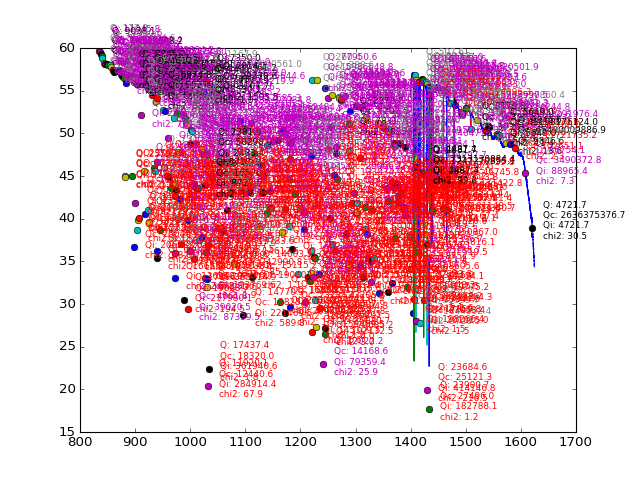

In [55]:
figure()
plot_results(sa.frequency,sa.s21_point,clean)

In [15]:
len(clean)

318

In [16]:
valid = [res for res in clean if validate_resonator(res)]

833604795.673 failed shallow
836066307.541 failed shallow
837311256.581 failed shallow
839015625.0 failed shallow
840218750.0 failed high range
844135970.143 failed shallow
846203120.58 failed low Q
846150305.489 failed shallow
846659399.022 failed shallow
849279990.872 failed shallow
850002568.732 failed high Qer
855333869.428 failed shallow
857124677.37 failed shallow
859902335.591 failed shallow
859999848.131 failed shallow
861265625.0 failed low Q
862393754.568 failed shallow
867765625.0 failed low Qe
870034675.713 failed shallow
870870056.821 failed shallow
871593554.866 failed shallow
873031806.264 failed shallow
874829880.209 failed shallow
876372434.358 failed shallow
880035431.255 failed shallow
881001879.521 881734586.148 883977266.153 886671875.014 failed shallow
889966089.577 failed shallow
891890625.135 failed shallow
894728773.668 895431462.078 failed shallow
897223338.737 failed shallow
898360377.172 900004008.189 failed shallow
900607450.627 903671871.407 failed shallow

In [17]:
len(valid)

177

In [56]:
frequency = np.hstack([sa.frequency for sa in sas])
s21 = np.hstack([sa.s21_point for sa in sas])

<IPython.core.display.Javascript object>


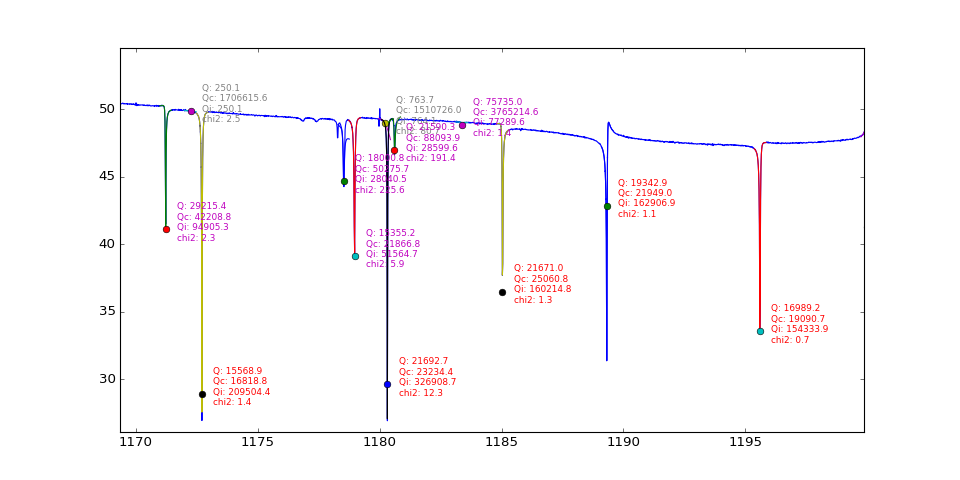

In [58]:
figure(figsize=(12,6))
plot_results(frequency,s21,clean,annotate=True)
#for x in np.arange(frequency.min(),frequency.max(),2*750e3)/1e6:
#    axvline(x,color='k',alpha=0.1)

In [38]:
bp = np.median(np.array([dB(sa.s21_point) for sa in sas]),0)

In [39]:
bp.shape

(16384,)

In [42]:
f0=np.array([res.f_0 for res in valid])

In [45]:
sa.stream_arrays[0].roach_state

StateDict({u'boffile': u'r2iq2xpfb14mcr16gb_2016_Jun_08_1100.bof', u'num_filterbank_channels': 16384, u'loopback': False, u'lo_frequency': 1400000000.0, u'adc_sample_rate': 512000000.0, u'modulation_output': 2, u'waveform_normalization': 0.00213623046875, u'num_tones': 256, u'modulation_rate': 7, u'debug_register': 0, u'dac_attenuation': 20.0, u'num_tone_samples': 32768, u'bank': 0, u'heterodyne': True})

<IPython.core.display.Javascript object>


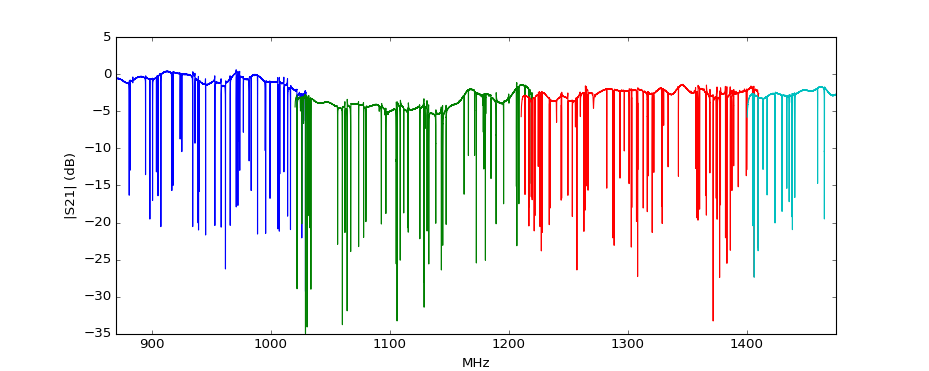

In [51]:
figure(figsize=(9,3))
for sa in sas:
    freq = sa.frequency_MHz
    bb = (sa.frequency-sa.stream_arrays[0].roach_state['lo_frequency'])/1e6
    bp = bb*(-10/200.)
    dbs21 = dB(sa.s21_point)-bp
    mask = (np.mod(freq,10.0) > .1) & (np.abs(np.mod(freq,10.0)-10.0) > .1) & (bb<200.)
    plot(freq[mask],dbs21[mask]-60)
ax = gca()
#ax.xaxis.set_major_locator(plt.MultipleLocator(20))
xlim(870,1475)
ax.set_ylabel('|S21| (dB)')
ax.set_xlabel('MHz')
#savefig('2016-06-23-hex-271-sweep.pdf',bbox_inches='tight')

<IPython.core.display.Javascript object>


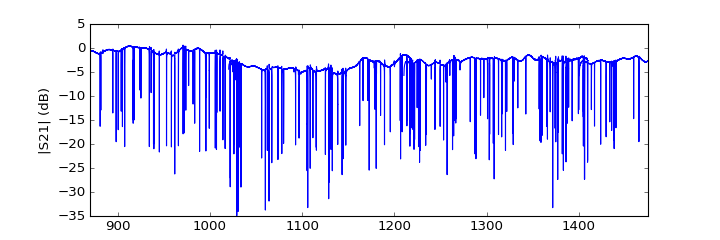

In [50]:
figure(figsize=(9,3))
for sa in sas:
    freq = sa.frequency_MHz
    bb = (sa.frequency-sa.stream_arrays[0].roach_state['lo_frequency'])/1e6
    bp = bb*(-10/200.)
    dbs21 = dB(sa.s21_point)-bp
    mask = (np.mod(freq,10.0) > .1) & (np.abs(np.mod(freq,10.0)-10.0) > .1) & (bb<200.)
    plot(freq[mask],dbs21[mask]-60,'b')
ax = gca()
#ax.xaxis.set_major_locator(plt.MultipleLocator(20))
xlim(870,1475)
ax.set_ylabel('|S21| (dB)')
ax.set_xlabel('MHz')
#savefig('2016-06-23-hex-271-sweep-same-color.pdf',bbox_inches='tight')

In [186]:
Qs=[res.Q for res in valid]

In [196]:
Qi = np.array([res.Q_i for res in valid])

In [188]:
Qc = [1/(np.real(1/res.Q_e)) for res in valid]

In [59]:
f0=np.array([res.f_0 for res in valid])

In [60]:
f0.shape

(177,)

In [61]:
np.save('/artemis/readout/resonances/2016-06-24-jpl-hex-271-all-auto-found-resonators.npy',f0)

In [217]:
mindifflist = f0[np.flatnonzero(np.diff(f0)>8*512e6/2**14)]

In [218]:
mindifflist.shape

(174,)

In [208]:
plot(f0)

In [190]:
np.median(f0)/1e6

1206.3700320657672

In [219]:
lo_1210_128=np.sort(mindifflist[np.sort(np.argsort(np.abs(mindifflist-1210e6))[:128])])

In [220]:
lo_1210_128.shape

(128,)

In [223]:
lo_1210_128

array([  9.99327257e+08,   1.00583564e+09,   1.00713254e+09,
         1.00752397e+09,   1.01098044e+09,   1.01407935e+09,
         1.01653087e+09,   1.02201442e+09,   1.02491063e+09,
         1.02601717e+09,   1.02749555e+09,   1.02911411e+09,
         1.03049176e+09,   1.03117267e+09,   1.03204778e+09,
         1.03257555e+09,   1.05610171e+09,   1.06015116e+09,
         1.06226744e+09,   1.06414088e+09,   1.06712588e+09,
         1.07376128e+09,   1.07794512e+09,   1.07990158e+09,
         1.09110041e+09,   1.09291421e+09,   1.09604144e+09,
         1.10538025e+09,   1.10572288e+09,   1.10610250e+09,
         1.10876096e+09,   1.11166011e+09,   1.11550686e+09,
         1.12520073e+09,   1.12875781e+09,   1.12995807e+09,
         1.13127615e+09,   1.13269388e+09,   1.13860098e+09,
         1.14330718e+09,   1.14441677e+09,   1.14731954e+09,
         1.16241086e+09,   1.16602466e+09,   1.17121048e+09,
         1.17270430e+09,   1.17896729e+09,   1.18031574e+09,
         1.18060189e+09,

<IPython.core.display.Javascript object>


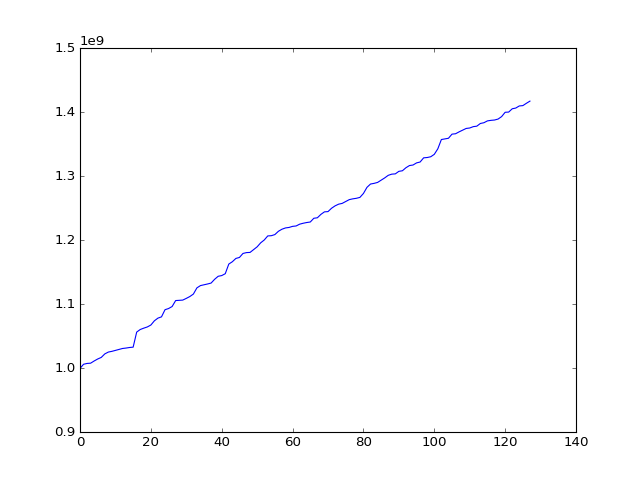

In [224]:
plot(lo_1210_128)

In [225]:
np.diff(lo_1210_128).min()

286149.50400972366

In [227]:
np.save('/artemis/readout/resonances/2016-06-22-lo-1210-128-resonances.npy',lo_1210_128)

In [177]:
np.mod(999.9e6,10e6)

9900000.0

In [178]:
np.array(f0)[(np.abs(np.mod(f0,10.0e6)) < 10e3) | (np.abs(np.mod(f0,10.0e6)-10e6) < 10e3)]/1e6

array([  959.99913324,   969.99455813,   979.99485914,   999.99431954,
        1010.00524783,  1020.00772099,  1480.00287086])

<IPython.core.display.Javascript object>


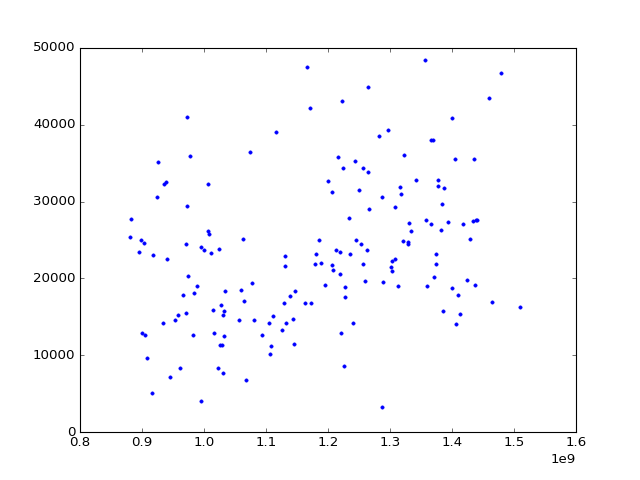

(0, 50000)

In [148]:
plot(f0,Qc,'.')
ylim(0,50000)

<IPython.core.display.Javascript object>


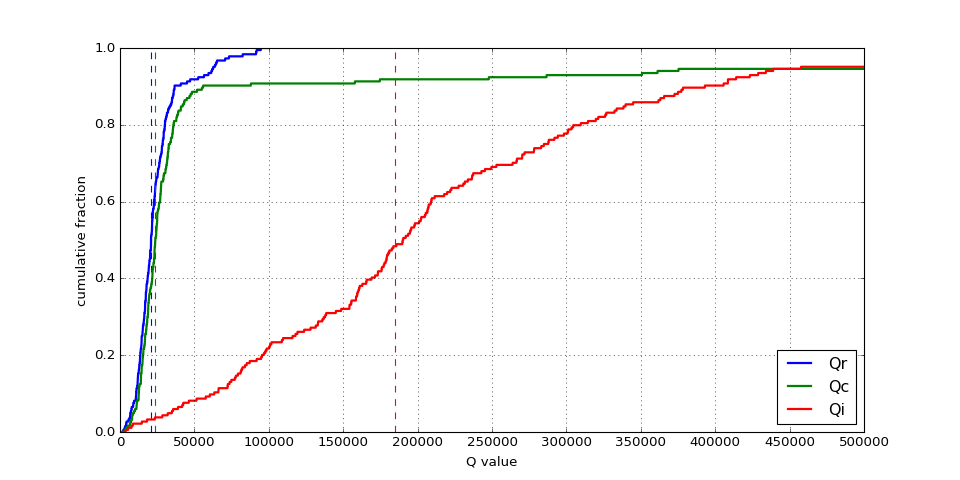

In [160]:
figure(figsize=(12,6))
h,edges = np.histogram(Qs,bins=np.arange(0,100e3,100))
plot(edges[:-1],np.cumsum(h)*1./len(Qs),label='Qr',color='b',lw=2)
axvline(np.median(Qs),color='b',linestyle='--')
h,edges = np.histogram(Qc,bins=np.arange(0,500e3,100))
plot(edges[:-1],np.cumsum(h)*1./len(Qs),label='Qc',color='g',lw=2)
axvline(np.median(Qc),color='g',linestyle='--')
h,edges = np.histogram(Qi,bins=np.arange(0,500e3,100))
plot(edges[:-1],np.cumsum(h)*1./len(Qs),label='Qi',color='r',lw=2)
axvline(np.median(Qi),color='r',linestyle='--')
ylabel('cumulative fraction')
xlabel('Q value')
grid()
legend(loc='lower right')
gca().xaxis.set_major_locator(plt.MultipleLocator(50e3))

<IPython.core.display.Javascript object>


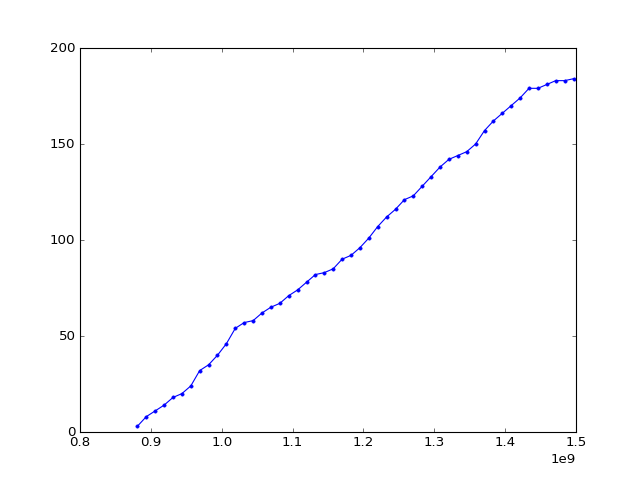

In [159]:
h,edges = np.histogram(f0,bins=50)
plot(edges[:-1],np.cumsum(h),'.-')

<IPython.core.display.Javascript object>


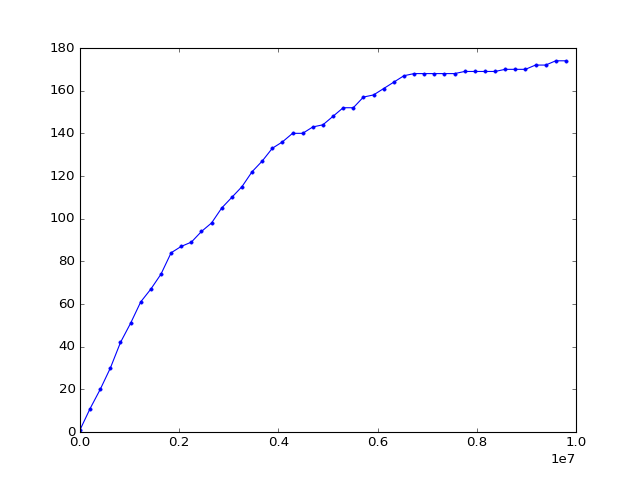

In [166]:
h,edges = np.histogram(np.diff(f0),bins=np.linspace(0,10e6,50))
plot(edges[:-1],np.cumsum(h),'.-')